## Data preprocessing<br>
The following cells require the Netflix Prize dataset to be downloaded and unzipped in a local folder or uploaded to a colab content folder.<br>
https://www.kaggle.com/datasets/netflix-inc/netflix-prize-data

In [4]:
### original data files are in format: 
# movie:
# user,rating,date
# ...
# user,rating,date
# movie:
# etc.
### This code block reformats all 4 original files into a single txt file with the format:
# movie,user,rating
# movie,user,rating
# etc.
### this makes it easier to load the data into a pandas dataframe for further processing
# runtime on modest system is approx 1 minute

fpaths = ["combined_data_1.txt", "combined_data_2.txt", "combined_data_3.txt", "combined_data_4.txt"]

with open('movie_user_rating_date_v1.txt', mode='a', encoding='utf-8') as f_write:
    for path in fpaths:
        print("Reading file: " + path)
        with open(path, mode='r', encoding='utf-8') as f_read:
            eof = False     # eof == end of file
            while not eof:         
                text = f_read.readline()    # iterate through each line
                if text == '':          # if end of file, readline() will be empty string ''
                    eof = True
                else:
                    if text[-2] == ':':     # lines with movie id have format '#:\n' 
                        movie = text[0:-2]
                    else:                   # if not line with movie id, append to "movie," and append line to datafile
                        append_text = movie + ',' + text
                        f_write.write(append_text)
print("Processing complete.")

Reading file: combined_data_1.txt
Reading file: combined_data_2.txt
Reading file: combined_data_3.txt
Reading file: combined_data_4.txt
Processing complete.


In [2]:
import pandas as pd
import numpy as np

In [5]:
# read combined txt file into dataframe

data_all = pd.read_csv('movie_user_rating_date_v1.txt', sep=',', names=['Movie','User','Rating','Date'])
# remove any rows with missing data
data_all = data_all.dropna(axis=0)
total_ratings = data_all.shape[0]
print(f"Total number of ratings: {total_ratings}")
data_all.head()

Total number of ratings: 100480507


,Movie,User,Rating,Date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [6]:
# sort data into top m movies with top u users based on number of ratings
# this reduces sparsity of user-movie matrix for PCA and model training

m = 2000    # number of top movies based on number of ratings: int, max=17770
u = 10000   # number of top users bases on number of ratings: int, max=480189

# the following code was adapted from https://www.kaggle.com/code/danofer/deep-learning-for-netflix-prize-challenge/notebook
top_data = pd.DataFrame()

group = data_all.groupby('User')['Rating'].count()
top_users = group.sort_values(ascending=False)[:u]

group = data_all.groupby('Movie')['Rating'].count()
top_movies = group.sort_values(ascending=False)[:m]

top_data = data_all.join(top_users, rsuffix='_uco', how='inner', on='User')
top_data = top_data.join(top_movies, rsuffix='_mco', how='inner', on='Movie')

# Re-name the users and movies for uniform name from 0..2000 and 10000
#user_enc = LabelEncoder()
#top_data['user'] = user_enc.fit_transform(top_data['User'].values)
#movie_enc = LabelEncoder()
#top_data['movie'] = movie_enc.fit_transform(top_data['movie_id'].values)
top_data.head()

,Movie,User,Rating,Date,Rating_uco,Rating_mco
5149,8,1488844,4,2005-05-12,2206,14910
5883,8,1227322,5,2005-05-31,4752,14910
6183,8,525356,4,2005-08-26,4913,14910
6310,8,401047,2,2005-06-15,2119,14910
7140,8,883478,5,2005-10-10,3222,14910


In [11]:
# always nice to output a save point

top_data.to_csv('top_data.csv', index_label=False)

In [ ]:
### code block if reloading notebook, skip if starting from beginning ###
top_data = pd.read_csv('top_data.csv')
top_data.head()

In [26]:
# check percentage of total ratings we keep in the top sorted dataframe

top_ratings = top_data.shape[0]
per_total = top_ratings / total_ratings * 100
print(f"Percent of total ratings: {per_total:.2f}")

Percent of total ratings: 9.58


### PCA<br>
The original Netflix Prize winners used matrix factorization to extract user and movie features from a user-movie matrix.<br>
Plotting these features showed groupings of similar movies. We hope to use the same concept, followed by a clustering algorithm, 
to generate a method of dimensionality reduction that can encode movies into a cluster or group.<br>
In order to make this feasible in the context of time for this project (and for grading it), we must reduce the number of
ratings we consider, as the user-movie matrix becomes quite large (and computationally inefficient) rather quickly.

In [7]:
# create user vs movie rating matrix from dataframe1 using randomly selected # of ratings (samples)
def make_user_movie_rating_matrix(dataframe1, samples):
    dataframe2 = dataframe1.sample(samples)
    data_zeros = pd.DataFrame()
    movies=[]
    users=[]
    for movie in dataframe2['Movie']:
        if movie not in movies:
            movies.append(movie)
    for user in dataframe2['User']:
        if user not in users:
            users.append(user)
    zero_array = np.zeros((len(users), len(movies)))
    data_zeros = pd.DataFrame(zero_array, columns=movies)
    data_zeros.insert(0, 'User', users)
    for i in range(len(dataframe2)-1):
        data_zeros.loc[dataframe2.iloc[i].at['User'], dataframe2.iloc[i].at['Movie']] = dataframe2.iloc[i].at['Rating']
    data_zeros = data_zeros.drop('User', axis=1)

    return data_zeros

In [8]:
data_for_PCA = make_user_movie_rating_matrix(top_data, 20000)

In [13]:
matrix_for_PCA = data_for_PCA.to_numpy(copy=True, na_value=0)
print(matrix_for_PCA.shape)

(17149, 1995)


In [11]:
from sklearn.decomposition import SparsePCA

In [14]:
# Use SparsePCA to decompose sparse user-movie rating matrix into 2 movie feature vectors
PCA_model1 = SparsePCA(n_components=2)
PCA_matrix = PCA_model1.fit_transform(matrix_for_PCA)

In [16]:
import seaborn as sns

[Text(0.5, 1.0, 'PCA, n=2')]

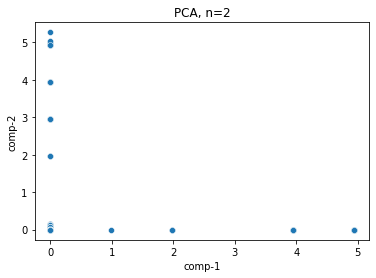

In [18]:
# scatterplot of PCA component1 vs PCA component2
df = pd.DataFrame()
df["comp-1"] = PCA_matrix[:,0]
df["comp-2"] = PCA_matrix[:,1]

sns.scatterplot(x="comp-1", y="comp-2",
                palette=sns.color_palette("hls", 2),
                data=df).set(title="PCA, n=2")

In [27]:
# Make sparse user-movie matrix from all users, movies in top_rated dataframe
# takes around 50-60 mins on modest system
data_for_KMeans = make_user_movie_rating_matrix(top_data, top_data.shape[0])

In [28]:
# another great time for a save point!
data_for_KMeans.to_csv('data_for_KMeans.csv', index_label=False)

In [52]:
### code if reloading notebook: ###
data_for_KMeans = pd.read_csv('data_for_KMeans.csv')

In [53]:
matrix_for_KMeans = data_for_KMeans.to_numpy(copy=True, na_value=0)
print(matrix_for_KMeans.shape)

(19963, 2000)


In [33]:
# Use SparsePCA to decompose sparse user-movie rating matrix into 2 movie feature vectors
PCA_model2 = SparsePCA(n_components=2)
PCA_matrix2 = PCA_model2.fit_transform(matrix_for_KMeans)

[Text(0.5, 1.0, 'SparsePCA components, n=2')]

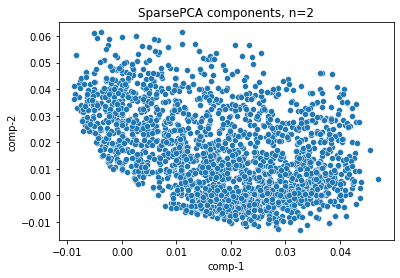

In [88]:
# scatterplot of SparsePCA component1 vs SparsePCA component2
df = pd.DataFrame()
df["comp-1"] = PCA_model2.components_[0]
df["comp-2"] = PCA_model2.components_[1]

sns.scatterplot(x="comp-1", y="comp-2",
                palette=sns.color_palette("hls", 2),
                data=df).set(title="SparsePCA components, n=2")

[Text(0.5, 1.0, 'SparsePCA, n=2')]

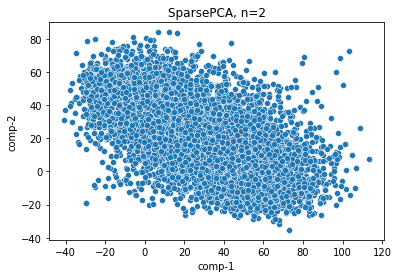

In [89]:
# scatterplot of SparsePCA component1 vs PCA component2
df = pd.DataFrame()
df["comp-1"] = PCA_matrix2[:,0]
df["comp-2"] = PCA_matrix2[:,1]

sns.scatterplot(x="comp-1", y="comp-2",
                palette=sns.color_palette("hls", 2),
                data=df).set(title="SparsePCA, n=2")

In [35]:
# look at sparsePCA with 3 components
PCA_model3 = SparsePCA(n_components=3)
PCA_matrix3 = PCA_model3.fit_transform(matrix_for_KMeans)

[Text(0.5, 1.0, 'PCA, n=3, comp1,2')]

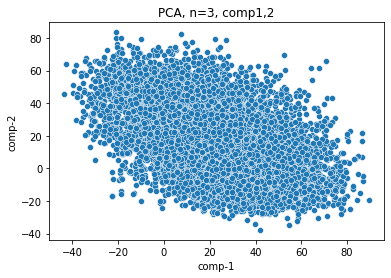

In [36]:
# scatterplot of PCA component1 vs PCA component2
df = pd.DataFrame()
df["comp-1"] = PCA_matrix3[:,0]
df["comp-2"] = PCA_matrix3[:,1]

sns.scatterplot(x="comp-1", y="comp-2",
                palette=sns.color_palette("hls", 2),
                data=df).set(title="SparsePCA, n=3, comp1,2")

[Text(0.5, 1.0, 'PCA, n=3, comp1,3')]

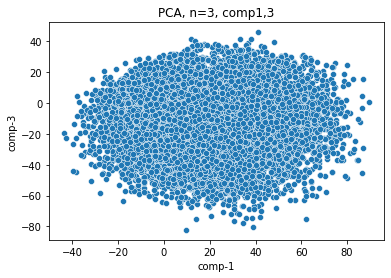

In [39]:
# scatterplot of PCA component1 vs PCA component2
df = pd.DataFrame()
df["comp-1"] = PCA_matrix3[:,0]
df["comp-3"] = PCA_matrix3[:,2]

sns.scatterplot(x="comp-1", y="comp-3",
                palette=sns.color_palette("hls", 2),
                data=df).set(title="SparsePCA, n=3, comp1,3")

[Text(0.5, 1.0, 'PCA, n=3, comp2,3')]

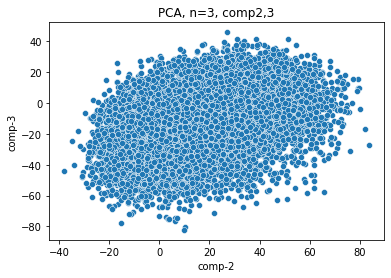

In [40]:
# scatterplot of PCA component2 vs PCA component3
df = pd.DataFrame()
df["comp-2"] = PCA_matrix3[:,1]
df["comp-3"] = PCA_matrix3[:,2]

sns.scatterplot(x="comp-2", y="comp-3",
                palette=sns.color_palette("hls", 2),
                data=df).set(title="SparsePCA, n=3, comp2,3")

In [92]:
from sklearn.decomposition import NMF
model_nmf = NMF(n_components=2, init='nndsvd', max_iter = 1000)
W = model_nmf.fit_transform(matrix_for_KMeans)
H = model_nmf.components_

[Text(0.5, 1.0, 'NMF, n=2')]

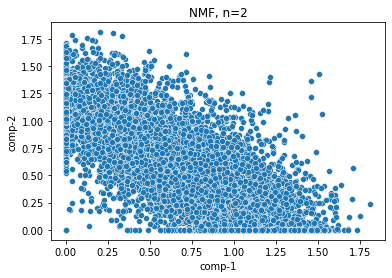

In [93]:
# scatterplot of NMF feature1 vs NMF feature2
df = pd.DataFrame()
df["comp-1"] = W[:,0]
df["comp-2"] = W[:,1]

sns.scatterplot(x="comp-1", y="comp-2",
                palette=sns.color_palette("hls", 2),
                data=df).set(title="NMF, n=2")

[Text(0.5, 1.0, 'NMF components, n=2')]

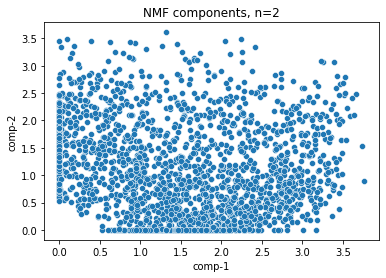

In [94]:
# scatterplot of NMF component1 vs NMF component2
df = pd.DataFrame()
df["comp-1"] = H[0]
df["comp-2"] = H[1]

sns.scatterplot(x="comp-1", y="comp-2",
                palette=sns.color_palette("hls", 2),
                data=df).set(title="NMF components, n=2")

In [55]:
from sklearn.decomposition import PCA

In [60]:
# normal PCA on data
PCA_model4 = PCA(n_components=2)
PCA_model4.fit(matrix_for_KMeans)
print(PCA_model4.components_)
print(PCA_model4.components_.shape)

[[ 0.01500239  0.02815788  0.02720474 ...  0.00742826  0.00417281
   0.00653414]
 [-0.01808674 -0.02914973 -0.02895501 ...  0.01696175  0.02081483
  -0.00925549]]
(2, 2000)


[Text(0.5, 1.0, 'PCA components, n=2')]

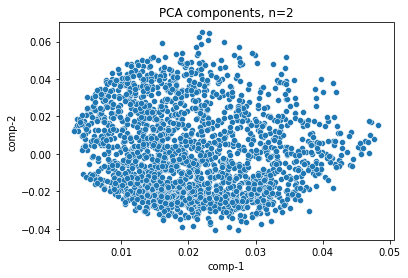

In [90]:
# scatterplot of PCA component1 vs PCA component2
df = pd.DataFrame()
df["comp-1"] = PCA_model4.components_[0,:]
df["comp-2"] = PCA_model4.components_[1,:]

sns.scatterplot(x="comp-1", y="comp-2",
                palette=sns.color_palette("hls", 2),
                data=df).set(title="PCA components, n=2")

Other than using the reduced sample sized matrix, PCA and NMF did not reveal a clear clustering of components. Below, we move on to clustering with different numbers of clusters and compare the results of each.

In [104]:
# example kmeans adapted from 
#   https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

from time import time
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# labels need to be removed or figure out how to use ratings
def bench_k_means(kmeans, name, data):
    """Benchmark to evaluate KMeans by number of clusters.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    #clustering_metrics = [metrics.homogeneity_score,metrics.completeness_score,metrics.v_measure_score,metrics.adjusted_rand_score,metrics.adjusted_mutual_info_score]
    #results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=1000)]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [114]:
data = matrix_for_KMeans

In [118]:
data = np.transpose(matrix_for_KMeans)

In [121]:
print("name\t\ttime\tinertia\t\tsilhouette")

kmeans7 = KMeans(init="k-means++", n_clusters=7, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans7, name="7 clusters", data=data)

kmeans8 = KMeans(init="k-means++", n_clusters=8, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans8, name="8 clusters", data=data)

kmeans9 = KMeans(init="k-means++", n_clusters=9, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans9, name="9 clusters", data=data)

kmeans10 = KMeans(init="k-means++", n_clusters=10, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans10, name="10 clusters", data=data)

kmeans11 = KMeans(init="k-means++", n_clusters=11, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans11, name="11 clusters", data=data)

kmeans12 = KMeans(init="k-means++", n_clusters=12, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans12, name="12 clusters", data=data)

kmeans13 = KMeans(init="k-means++", n_clusters=13, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans13, name="13 clusters", data=data)

kmeans14 = KMeans(init="k-means++", n_clusters=14, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans14, name="14 clusters", data=data)

kmeans15 = KMeans(init="k-means++", n_clusters=15, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans15, name="15 clusters", data=data)

kmeans20 = KMeans(init="k-means++", n_clusters=20, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans20, name="20 clusters", data=data)

kmeans22 = KMeans(init="k-means++", n_clusters=22, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans22, name="22 clusters", data=data)

kmeans24 = KMeans(init="k-means++", n_clusters=24, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans24, name="24 clusters", data=data)

kmeans26 = KMeans(init="k-means++", n_clusters=26, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans26, name="26 clusters", data=data)

kmeans30 = KMeans(init="k-means++", n_clusters=30, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans30, name="30 clusters", data=data)

name		time	inertia		silhouette
7 clusters	4.207s	15333254	0.044
8 clusters	3.584s	15158665	0.036
9 clusters	4.413s	15002806	0.038
10 clusters	5.054s	14887548	0.034
11 clusters	4.398s	14809747	0.027
12 clusters	4.446s	14694801	0.032
13 clusters	4.902s	14588717	0.027
14 clusters	5.822s	14504855	0.021
15 clusters	5.361s	14382524	0.030
20 clusters	6.233s	14037951	0.027
22 clusters	6.343s	13932703	0.031
24 clusters	7.452s	13846164	0.027
26 clusters	7.772s	13743517	0.032
30 clusters	8.109s	13552414	0.028


We see a reduction in inertia as we increase K, but that reduction becomes less noticeable after 20 clusters. Let's visualize K=12, 15, and 20 using PCA reduced data.

K-means clustering (K=12) on the user-movie data (PCA-reduced data)
Centroids are marked with white cross


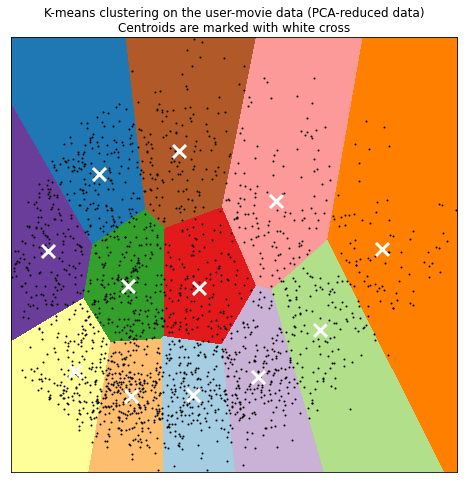

In [122]:
import matplotlib.pyplot as plt

print("K-means clustering (K=12) on the user-movie data (PCA-reduced data)\nCentroids are marked with white cross")

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans_r = KMeans(init="k-means++", n_clusters=12, n_init=4)
kmeans_r.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans_r.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=[8,8])
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans_r.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the user-movie data (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

K-means clustering (K=15) on the user-movie data (PCA-reduced data)
Centroids are marked with white cross


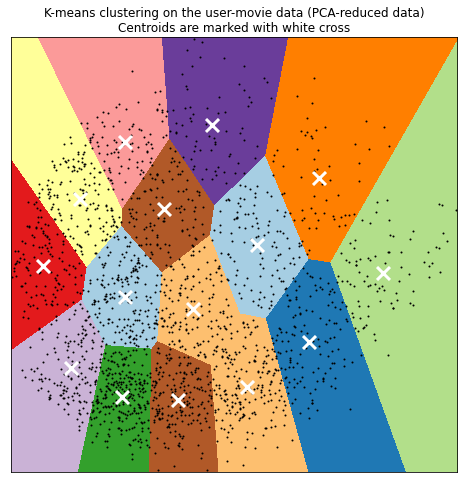

In [123]:
print("K-means clustering (K=15) on the user-movie data (PCA-reduced data)\nCentroids are marked with white cross")

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans_r = KMeans(init="k-means++", n_clusters=15, n_init=4)
kmeans_r.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans_r.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=[8,8])
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans_r.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the user-movie data (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

K-means clustering (K=20) on the user-movie data (PCA-reduced data)
Centroids are marked with white cross


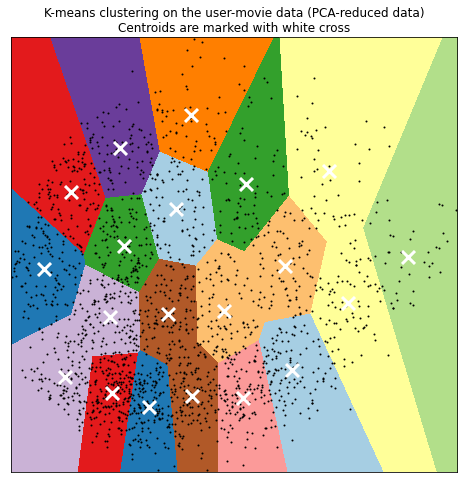

In [124]:
print("K-means clustering (K=20) on the user-movie data (PCA-reduced data)\nCentroids are marked with white cross")

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans_r = KMeans(init="k-means++", n_clusters=20, n_init=4)
kmeans_r.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans_r.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=[8,8])
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans_r.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the user-movie data (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### Relabeling Movies using KMeans clustering

In [170]:
def relabel_movies(df, series, kmeans):
    '''function to relabel movies by cluster

    Parameters
    ----------
    df : Pandas Dataframe
        Dataframe with original movie column
    series : str or int
        Series name or index for column containing movie ids to be relabeled
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance used to relabel movies
    ----

    returns : Pandas Dataframe
    '''

    new_df = pd.DataFrame
    new_df = df.copy()

    # create mapping dictionary using kmeans and remap movie column
    map_dict = dict(zip(list(df[series].unique()), list(kmeans.labels_)))
    new_df[series] = new_df[series].map(map_dict)

    return new_df

In [171]:
top_data_dimreduce = relabel_movies(top_data, 'Movie', kmeans20)
top_data_dimreduce.head()

,Movie,User,Rating,Date,Rating_uco,Rating_mco
5149,9,1488844,4,2005-05-12,2206,14910
5883,9,1227322,5,2005-05-31,4752,14910
6183,9,525356,4,2005-08-26,4913,14910
6310,9,401047,2,2005-06-15,2119,14910
7140,9,883478,5,2005-10-10,3222,14910


In [173]:
print(top_data_dimreduce['Movie'].shape)
print(top_data_dimreduce['Movie'].unique())

(9623666,)
[ 9 11  1 10 17  7  3 12 13  0  2 19  8 18  4 15 14 16  5  6]


In [174]:
# output reduced movie dataframe as csv
top_data_dimreduce.to_csv('top_data_dimreduce_20.csv')